In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
import os
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Overview


Electricity has always been at the heart of residents’ daily life, industrial production, and transportation. 

A reliable prediction of electricity price can help people and businesses to plan ahead, avoid unnecessary cost and maximize output. 

This project aims to collect data on electricity generation, fuel consumption and weather conditions of state of Virginia to form a model to predict future electricity price in Virginia.

# Methods

### Methods consider using


According to the Energy Informatio Administration, fuel, transportation, power plant cost, weather condition and regulation have great impact on electricity price. 

This project will employ both traditional machine learning techniques such as linear regression, KNN and random forest and Time Series methods to generate a plausible model for predicting future electricity price and gain insights from the models. 

###  Methods used to date


### traditional machine learning:

Linear Model

KNN with K tuning param

Decision Tree regression with the Max Depth Param

The Bagging decision tree regression model 

Random forest with the N Estimators and max_depth tuning param

### Time Seires model:

ARIMA

# Preliminary Results

In [2]:
full_data = pd.read_csv("../main/full_data")
full_data = full_data.drop(columns=['Other Gases (Billion BTU)'])

#split the data.
y = full_data[['PRICE(Cents/kWh.5)']]
X = full_data.drop(columns=['PRICE(Cents/kWh.5)', 'DATE'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .20,random_state=520)
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['GENERATION\n(Megawatthours)', 'Coal (Short Tons)', 'Natural Gas (Mcf)',  'Petroleum (Barrels)', 'internet_search', 'AverageTemperature', 'Precipitation'])])

pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[3,5,10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()],
     'model__random_state':[0]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3,4,5],
     'model__n_estimators':[100, 300,500,700,900],
     'model__random_state':[0]},
]

search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

search.fit(train_X,train_y['PRICE(Cents/kWh.5)'])

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['GENERATION\n'
                                                                          '(Megawatthours)',
                                                                          'Coal '
                                                                          '(Short '
                                                                          'Tons)',
                                                                          'Natural '
                                                                          'Gas '
                                                                          '(Mcf)',
                           

In [3]:
search.best_params_

{'model': RandomForestRegressor(max_depth=5, n_estimators=300, random_state=0),
 'model__max_depth': 5,
 'model__n_estimators': 300,
 'model__random_state': 0}

In [4]:
pred_y = search.predict(test_X)

m.r2_score(test_y,pred_y)


0.8956119467795509

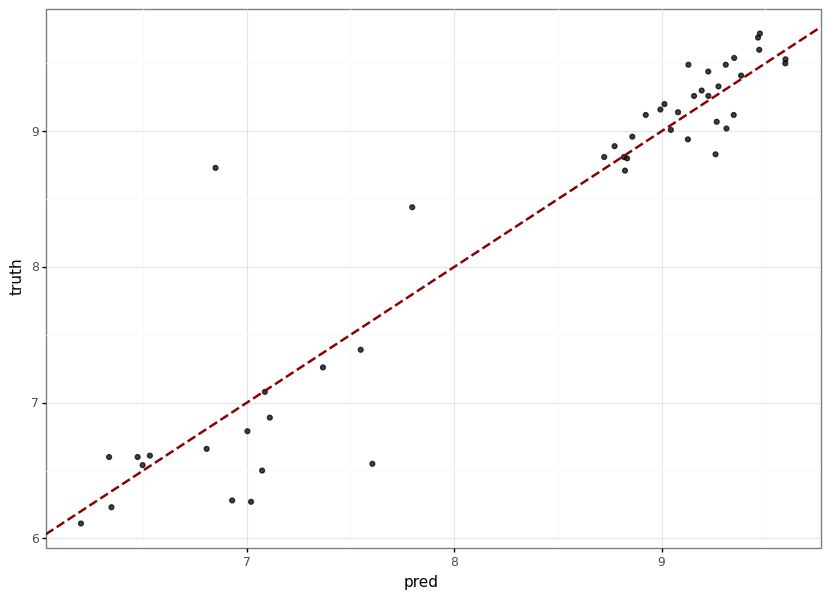

<ggplot: (8784572362286)>

In [5]:

(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y['PRICE(Cents/kWh.5)'])),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

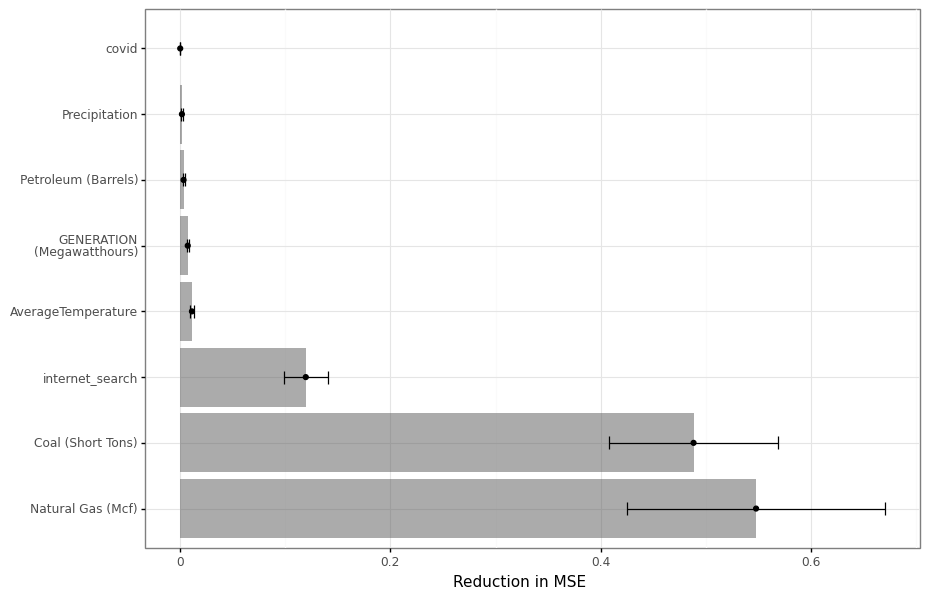

<ggplot: (8784572812972)>

In [6]:
best_mod = search.best_estimator_

vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in MSE",x="") +
    theme(figure_size=(10,7))
)

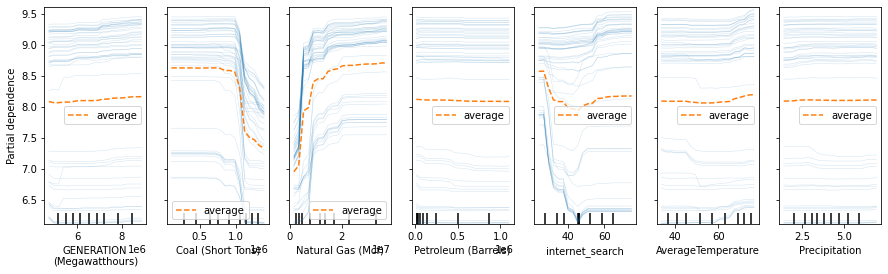

In [7]:
features = ['GENERATION\n(Megawatthours)', 'Coal (Short Tons)', 'Natural Gas (Mcf)',  'Petroleum (Barrels)', 'internet_search', 'AverageTemperature', 'Precipitation']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    best_mod,
    train_X,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)

In [8]:
ts_dat = full_data[['DATE', 'PRICE(Cents/kWh.5)']].copy()
ts_dat['DATE'] = pd.to_datetime(ts_dat['DATE'])
ts_dat = ts_dat.set_index(['DATE'])

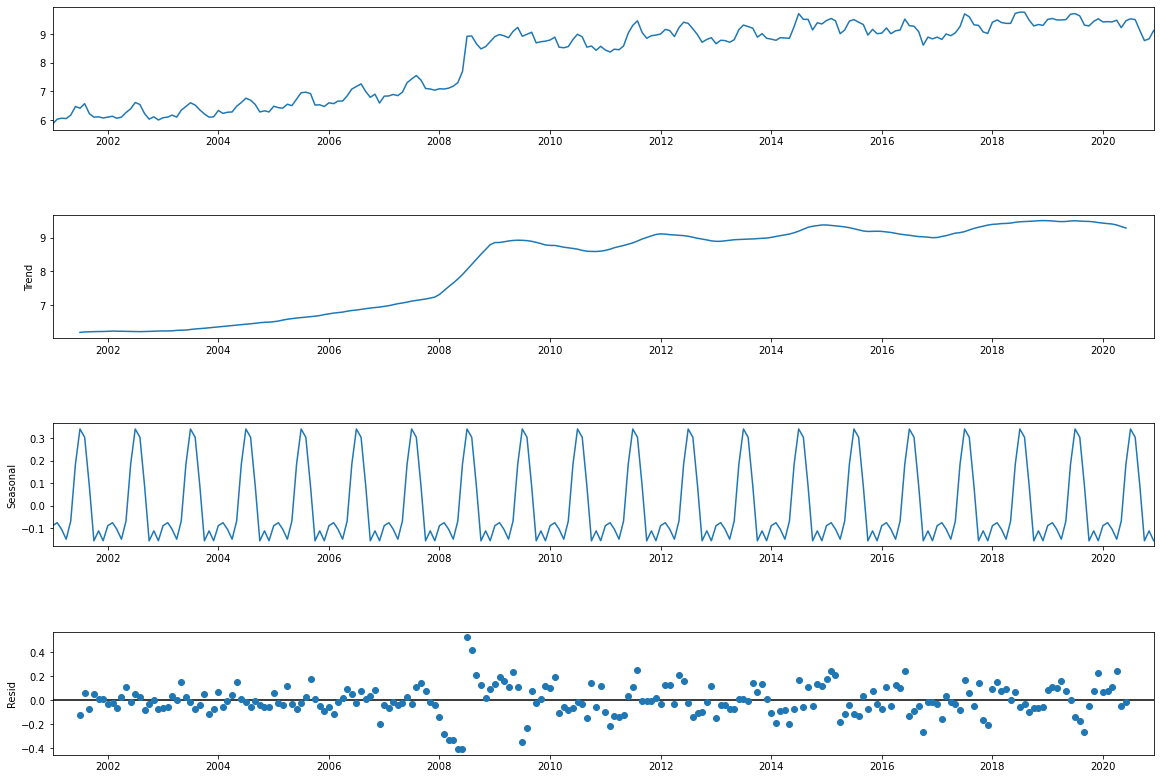

In [9]:
deco = sm.tsa.seasonal_decompose(ts_dat, model='additive')
fig = deco.plot()
plt.gcf().set_size_inches(18, 12)
plt.show()

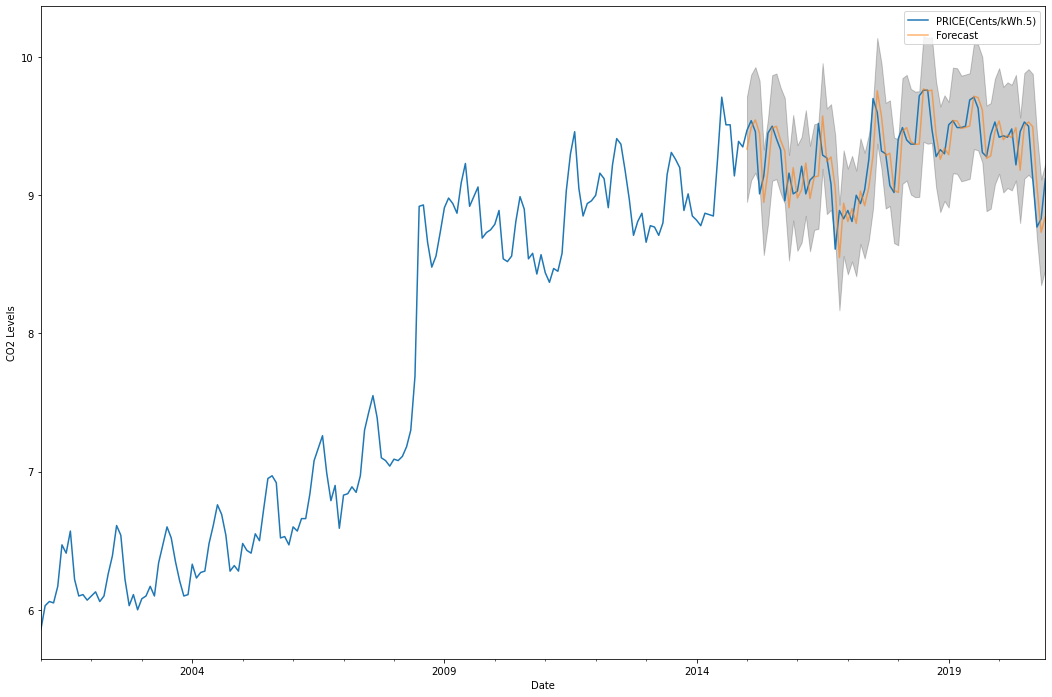

In [10]:
mod = sm.tsa.statespace.SARIMAX(ts_dat,
                                order=(1, 1, 1),
				)

TSresults = mod.fit()

#print(TSresults.summary().tables[1])

pred = TSresults.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters. 

ax = ts_dat['2001':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.gcf().set_size_inches(18, 12)
plt.legend()

plt.show()

# Future efforts


Boost up the importance of weather conditions

Add the prices of coal and gas

Add another dummy variable to control for the financial crisis